## Import modules and functions

In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
import matplotlib.patches as patches
import matplotlib.colors as colors

import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import glob
import re
import os
import math

import pylab as pl
import matplotlib
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from scipy.signal import savgol_filter

from matplotlib.gridspec    import GridSpec
import import_ipynb

import Module_Diagnostics as MD
import numpy as np
from tempfile import mkdtemp
import os.path as path
import sys

from pathlib import Path
import json

#Debugger. For some reason, using it inside a function works well. Otherwise...
from IPython.core.debugger import set_trace
#exemple: 
# def debug():
#     set_trace()
    
#     `code_to_debug`
    
#     return

# debug()

importing Jupyter notebook from Module_Diagnostics.ipynb
testing compute_RMS(...):
This should be close to 1: 1.001576407377528
This should be close to 0: 0.0


## Plot parameters

In [23]:
# %matplotlib notebook
f=2
rcParams["figure.figsize"] = [9.4*f, 4.8*f]
# matplotlib.use('nbagg') #_comment this line if you don't need to interact with plots (zoom, translations, savings...)

# import matplotlib
# matplotlib.use('TkAgg')

## Choose run and time for analysis

In [3]:
run_name = 'RUN_NAME'

loop = False #LOOP #(LOOP is a boolean)
time = 230 #TIME
time = '%05d' % time    # Change the time to string format, needed by functions

### Only for use:

#if working on lx-moissard
Cluster = 'Occ/'
run_name = '20_08_18_new_big_one_0'
filepath = '/data/Lathys/Visualisation/' + Cluster + run_name + '/ncfiles/'

#if working on occigene
# filepath = '../ncfiles/'

try:
    date = re.search('Magw_(.+?)_t', glob.glob(filepath+'Magw*_t'+time+'.nc')[0]).group(1)
except (IndexError, AttributeError): 
    sys.exit(f"""time_dump {time} does not appear to have data.
             Let us go to the next time_dump""")

print(f'date of the simulation (DD_MM_YY): {date}')
print(f'time dump (in 1/omega_ci): {time}')

#This is used by the functions find_ip_shock(N, V) and find_mc_leading_edge(B)
metadata = {'t_shock_entrance' : 130,
            't_shock_exit'     : 240,
            't_MC_entrance'    : 130,
            't_MC_exit'        : 270}
#todo: autodefine t_collision? maybe from story_reader will be easier, as lines will cross on the multivariate plot

date of the simulation (DD_MM_YY): 18_08_20
time dump (in 1/omega_ci): 00230


In [4]:
# Prepare for plt.savefig
storing_directory = filepath + "../structure_images/"
path_png = Path(storing_directory)
time_label = f"t{time}"
if path_png.exists():
    pass
else:
    path_png.mkdir()

In [5]:
storing_directory_json = filepath + "../json_files/"

path_store_json = Path(storing_directory_json)

if not(path_store_json.exists()):
    os.system(f'mkdir {path_store_json}')

name = "sav_shock_understanding_" + run_name + ".json"
path_json = Path(storing_directory_json + name)

In [6]:
#The next line links directly to my PhD_Manuscript on Overleaf.com
#Saving plots there means that I do not need to worry about having the very last versions before
#starting to write about it in Overleaf, since they will always be up-to-date.

#IMPORTANT: for it to work, add the following line to ~/.bashrc
#export DROPBOX="/home/moissard/Dropbox" (to adapt to the particular machine)
dropbox = os.environ['DROPBOX']
dropbox_dir = "./" #dropbox + "/Apps/Overleaf/PhD_Manuscript/Images/LATHYS/"

# plt.savefig(dropbox_dir + '/' + saving_title + run_name + ".png",
#             transparent=True, bbox_inches='tight', pad_inches=0.1)

#If not working on the manuscript anymore, avoid changing images there by mistake
dropbox_dir = storing_directory

## Load data to large 3D arrays: N, (Bx, By, Bz), _etc._

#### Clear /tmp

In [7]:
print("""Clearing up /tmp/ ...
Indeed by using memmap, this code creates heavy temporary files""")
#Note: >/dev/null 2>&1 makes the system silent. Usually this command raises a lot of
# 'Action not permitted'. But that's fine. Nothing to debug here. tmp/ is full of
# files that should not be deleted, which are protected by root privileges.
os.system('rm -rf /tmp/* >/dev/null 2>&1')

Clearing up /tmp/ ...
Indeed by using memmap, this code creates heavy temporary files


256

### Load B, n, E, T, V

In [8]:
## Load B and X, Y, Z

# There might be some MemoryError. In that case, follow the guide:
# https://stackoverflow.com/questions/60563936/memoryerror-unable-to-allocate-3-78-gib-for-an-array-with-shape-802-842-1502
Magw = MD.import_data_3D(filepath, date, time, 'Magw')

cwp = Magw['c_omegapi'][0]
gstep = Magw['gstep']
r_planet = Magw['r_planet'][0]

#Thomas Huret recommands shifting the axes so that the planet is indeed in (0,0,0)
#It has got something to do with lists starting at 1 instead of 0 in Fortran...?
X = np.array(np.around(Magw['x']))#+gstep[0]  
Y = np.array(np.around(Magw['y']))#+gstep[1]
Z = np.array(np.around(Magw['z']))#-gstep[2]

nx,  ny,  nz  = len(X), len(Y), len(Z)
# Location of the planet is defined in the .ncfiles as (x,y,z) = (0,0,0)
# Location of the planet is defined in the .ncfiles as (x,y,z) = (0,0,0)
nx0, ny0, nz0 = ( int(np.where(abs(X)==min(abs(X)))[0]),
                  int(np.where(abs(Y)==min(abs(Y)))[0]), 
                  int(np.where(abs(Z)==min(abs(Z)))[0])  )
            
# Use memmap to alleviate RAM
# This stores big arrays on the disk, but in a way that still allows for most
# operations available on an np.array
print("storing Magnetic field in a memmap")
file_Bx = path.join(mkdtemp(), 'Bx.dat')            
Bx = np.memmap(file_Bx, dtype='float32', mode='w+', shape=(nx,ny,nz))
Bx[:] = Magw['Bx']
file_By = path.join(mkdtemp(), 'By.dat')            
By = np.memmap(file_By, dtype='float32', mode='w+', shape=(nx,ny,nz))
By[:] = Magw['By']
file_Bz = path.join(mkdtemp(), 'Bz.dat')            
Bz = np.memmap(file_Bz, dtype='float32', mode='w+', shape=(nx,ny,nz))
Bz[:] = Magw['Bz']
print("deleting Magw to alleviate RAM")
del Magw
B = [Bx, By, Bz]

## Load E
# Electric field in mV/m
Elew = MD.import_data_3D(filepath, date, time, 'Elew')
print("storing Electric field in a memmap")
file_Ex = path.join(mkdtemp(), 'Ex.dat')            
Ex = np.memmap(file_Ex, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ex[:] = Elew['Ex']*1e6
file_Ey = path.join(mkdtemp(), 'Ey.dat')            
Ey = np.memmap(file_Ey, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ey[:] = Elew['Ey']*1e6
file_Ez = path.join(mkdtemp(), 'Ez.dat')            
Ez = np.memmap(file_Ez, dtype='float32', mode='w+', shape=(nx,ny,nz))
Ez[:] = Elew['Ez']*1e6
print("deleting Elew to alleviate RAM")
del Elew
E = [Ex, Ey, Ez]

## Load N, Vxyz, and T
Hsw = MD.import_data_3D(filepath, date, time, 'Hsw')
print("storing Plasma parameters in memmaps")
# Density in nb/cm^3
file_N = path.join(mkdtemp(), 'N.dat')            
N = np.memmap(file_N, dtype='float32', mode='w+', shape=(nx,ny,nz))
N[:] = Hsw['n']
# Velocity in km/s
file_Vx = path.join(mkdtemp(), 'Vx.dat')            
Vx = np.memmap(file_Vx, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vx[:] = Hsw['Vx']
file_Vy = path.join(mkdtemp(), 'Vy.dat')            
Vy = np.memmap(file_Vy, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vy[:] = Hsw['Vy']
file_Vz = path.join(mkdtemp(), 'Vz.dat')            
Vz = np.memmap(file_Vz, dtype='float32', mode='w+', shape=(nx,ny,nz))
Vz[:] = Hsw['Vz']
# Temperature in eV
file_T = path.join(mkdtemp(), 'T.dat')            
T = np.memmap(file_T, dtype='float32', mode='w+', shape=(nx,ny,nz))
T[:] = Hsw['T']
print("deleting Hsw to alleviate RAM")
del Hsw
V = [Vx, Vy, Vz]

Importing Magw 3D from /data/Lathys/Visualisation/Occ/20_08_18_new_big_one_0/ncfiles/
Reading Bx...
Reading By...
Reading Bz...
Close file and return...
storing Magnetic field in a memmap
deleting Magw to alleviate RAM
Importing Elew 3D from /data/Lathys/Visualisation/Occ/20_08_18_new_big_one_0/ncfiles/
Reading Ex...
Reading Ey...
Reading Ez...
Close file and return...
storing Electric field in a memmap
deleting Elew to alleviate RAM
Importing Hsw 3D from /data/Lathys/Visualisation/Occ/20_08_18_new_big_one_0/ncfiles/
Reading density...
Reading Ux...
Reading Uy...
Reading Uz...
Reading T...
Close file and return...
storing Plasma parameters in memmaps
deleting Hsw to alleviate RAM


In [9]:
np.shape(Bx)

(1502, 722, 662)

## Choose cubes

### Def cubes

In [10]:
def build_cubes(position_shock):
    
    '''Defines two cubes: one on the left and one on the right side of
       a point.'''
    
    distance = 7
    size_cubes = 6 # Goals and poles. This will be a 5 by 5 cube.
    
    x_shock = position_shock[0]
    y_shock = position_shock[1]
    z_shock = position_shock[2]
    
    center_cube = x_shock, y_shock, z_shock

    cube_x_max = x_shock + size_cubes/2
    cube_x_min = x_shock - size_cubes/2
    cube_y_max = y_shock + size_cubes/2
    cube_y_min = y_shock - size_cubes/2
    cube_z_max = z_shock + size_cubes/2
    cube_z_min = z_shock - size_cubes/2

    ix_min_left  = int(np.where(cube_x_min + distance <=X)[0][0])    
    ix_max_left  = int(np.where(cube_x_max + distance <=X)[0][0])
    ix_min_right = int(np.where(cube_x_min - distance <=X)[0][0])    
    ix_max_right = int(np.where(cube_x_max - distance <=X)[0][0])
    iy_min = int(np.where(cube_y_min<=Y)[0][0])
    iy_max = int(np.where(cube_y_max<=Y)[0][0])
    iz_min = int(np.where(cube_z_min<=Z)[0][0])
    iz_max = int(np.where(cube_z_max<=Z)[0][0])
    
    cubes = {'left':
              { 'coord': (cube_x_min+distance, cube_x_max+distance, cube_y_min, cube_y_max, cube_z_min, cube_z_max),
                'index': (ix_min_left , ix_max_left , iy_min, iy_max, iz_min, iz_max) },
             
             'right': 
              { 'coord': (cube_x_min-distance, cube_x_max-distance, cube_y_min, cube_y_max, cube_z_min, cube_z_max),
                'index': (ix_min_right, ix_max_right, iy_min, iy_max, iz_min, iz_max) }
             }
    
    return cubes

### Locate cubes

In [11]:
#for '20_08_18_new_big_one_0', at t=230
# cube = (xmin, xmax, ymin, ymax, zmin, zmax)
position_shock_xy_sw = (-65, 180, 0)
position_shock_xy_bs = (-63, 135, 0)
# position_shock_xy_mp = (-50,  76, 0)
position_shock_xy_mp = (-55,  90, 0)

cubes_xy_sw = build_cubes(position_shock_xy_sw)
cubes_xy_bs = build_cubes(position_shock_xy_bs)
cubes_xy_mp = build_cubes(position_shock_xy_mp)

position_shock_xz_sw = (-67, 0, 186)
position_shock_xz_bs = (-67, 0, 150)
# position_shock_xz_mp = (-71, 0,  87)
position_shock_xz_mp = (-70, 0,  85)

cubes_xz_sw = build_cubes(position_shock_xz_sw)
cubes_xz_bs = build_cubes(position_shock_xz_bs)
cubes_xz_mp = build_cubes(position_shock_xz_mp)

## Plot global view

### Define plot_colormap

In [12]:
def plot_colormap(A, title, label, plane,
                  ratio_max_to_med = 4,
                  cubes = None, dashes = None,
                  save_dir = None, t_label = None, 
                  zoom = None, density = 1, linewidth = 1, map_color='plasma',
                  streamplot = None, Bx = None, Bj = None,
                  min_value=None, max_value=None, lines_0=None, midpoint=0):
    
    if not(max_value):
        max_value = int(np.median(A[np.isfinite(A) & (A > 0)])*ratio_max_to_med)
    
    if not(min_value):
        if (A < 0).any():
            min_value = int(np.median(A[np.isfinite(A) & (A < 0)])*ratio_max_to_med) 
        else:
            min_value = int(np.min(A))

       
    # Number of color levels
    levels = MaxNLocator(nbins=255).tick_values(min_value, max_value)
    nb_ticks = 11
    cbar_ticks = list(MaxNLocator(nbins=nb_ticks).tick_values(min_value, max_value))
    while ( len(cbar_ticks) < nb_ticks ) :
        cbar_ticks.append(r"$\infty$")
    cmap = plt.get_cmap(map_color)
    
    if (A < midpoint).any():
        norm = colors.DivergingNorm(vmin=min_value, vcenter=midpoint, vmax=max_value)
#         norm = MidpointNormalize(vmin=min_value, vmax=max_value, midpoint=midpoint)
    else:
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)

    plt.close('all')
    plt.figure(figsize=(7, 7))
    ax = plt.gca()
             
    if zoom:
        xmin, xmax, ymin, ymax, zmin, zmax = zoom

    else:
        xmin, xmax, ymin, ymax, zmin, zmax = (min(X), max(X),
                                              min(Y), max(Y),
                                              min(Z), max(Z))
    
    if plane=='xy':
        plot = pl.pcolor(X, Y, A.T, cmap=cmap, norm=norm) 
        plt.xlabel('x', fontsize = 16, weight="bold")
        plt.ylabel('y', fontsize = 16, weight="bold")
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
        
        k1=2
        k2=3
        j1=1
                
    if plane=='xz':
        plot = pl.pcolor(X, Z, A.T, cmap=cmap, norm=norm) 
        plt.xlabel('x', fontsize = 16, weight="bold")
        plt.ylabel('z', fontsize = 16, weight="bold")
        plt.xlim([xmin, xmax])
        plt.ylim([zmin, zmax])
        
        k1=4
        k2=5
        j1=2

    if cubes:
        for cube in cubes:

            Ox = cube[0]
            Oy = cube[k1]
            Lx = abs(cube[1] - cube[0])
            Ly = abs(cube[k2] - cube[k1])

            rect = patches.Rectangle((Ox, Oy), Lx, Ly, linewidth=1, edgecolor='black', facecolor='cyan')
            ax.add_patch(rect)
            
    if dashes:
        for dash in dashes:
            ax.scatter(dash[0], dash[j1], color="cyan", marker=">")

    plt.title(title +'\n', fontsize = 16, weight="bold")
    
    if lines_0:
        plt.axhline(Y=0, linewidth=4, color='w')
        plt.axvline(X=0, linewidth=4, color='w')
        
#     plt.gca().invert_xaxis()
    plt.gca().set_aspect('equal')
    ax = plt.gca()
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax, cmap=cmap, norm=norm)
    if not((A < 0).any()):
        try:
            cbar.ax.set_yticklabels(cbar_ticks) #, fontsize=16, weight='bold')
        except ValueError:
            pass
    cbar.ax.set_yticklabels(["{:.1f}".format(i) for i in cbar.get_ticks()])
    cbar.set_label(label, rotation=270, fontsize = 16, weight="bold", labelpad=20)
                            
    if (streamplot): 
        # Magnetic field lines
        
        if plane=='xy':
            ax.streamplot(X, Y, Bx.transpose(), Bj.transpose(), linewidth=linewidth, density=density, color="lightgrey")
        if plane=='xz':
            ax.streamplot(X, Z, Bx.transpose(), Bj.transpose(), linewidth=linewidth, density=density, color="lightgrey")

    ax.invert_xaxis()

    try:
        if save_dir and t_label:
            title = title.replace(" ", "")
            title = title.replace(".", "")
            title = title.replace("#", "")
            title = title.replace("é", "e")
            svg_name = t_label + title + '_' + plane + run_name
            plt.savefig(save_dir + svg_name + ".png",
                        transparent = True, bbox_inches='tight', pad_inches=0.1)
    except: 
        print("Please specify both save_dir and t_label")
        
    if not(loop):
        plt.show()
                  
    return ax

In [13]:
cubes_xy_sw['right']['coord']

(-75.0, -69.0, 177.0, 183.0, -3.0, 3.0)

### Plots

In [14]:
xmin = min(X)
xmax = 3*abs(xmin)   #Most of the length in the x direction is used to give space for the sheath to form
                     #It is not really interesting
zoom = (xmin, xmax, min(Y), max(Y), min(Z), max(Z))
zoom = (-100, 70, -200, 200, -200, 200)

# %matplotlib notebook

#### Density

<IPython.core.display.Javascript object>


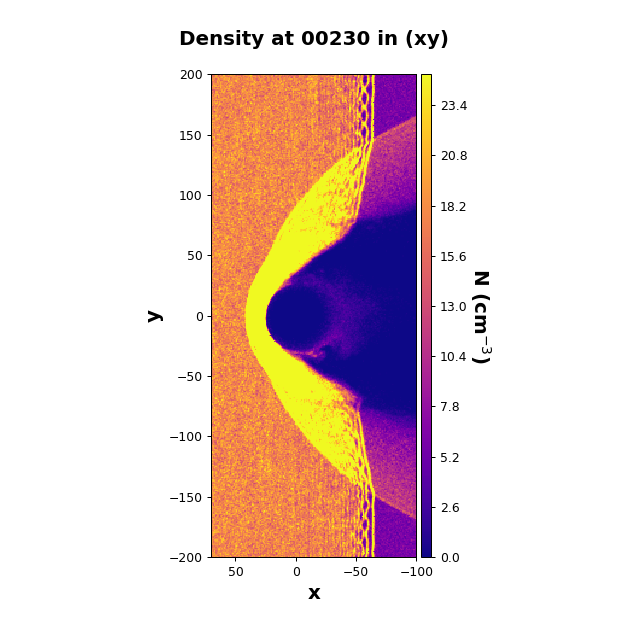

In [32]:
plot_colormap(N[:,:,nz0], f'Density at {time} in (xy)', r'N (cm$^{-3}$)', 'xy',
#               cubes = [cubes_xy_sw['right']['coord'],
#                        cubes_xy_bs['right']['coord'],
#                        cubes_xy_mp['right']['coord']],
                 save_dir = storing_directory, t_label = time_label, zoom = zoom)

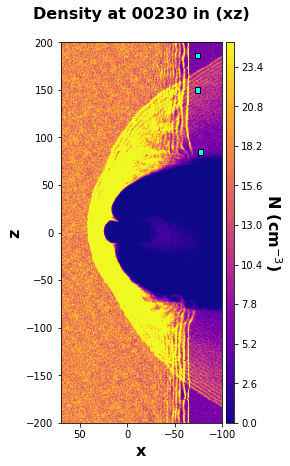

In [16]:
plot_colormap(N[:,ny0,:], f'Density at {time} in (xz)', r'N (cm$^{-3}$)', 'xz',
              cubes = [cubes_xz_sw['right']['coord'],
                       cubes_xz_bs['right']['coord'],
                       cubes_xz_mp['right']['coord']],
                 save_dir = storing_directory, t_label = time_label, zoom = zoom)

#### Current

<IPython.core.display.Javascript object>


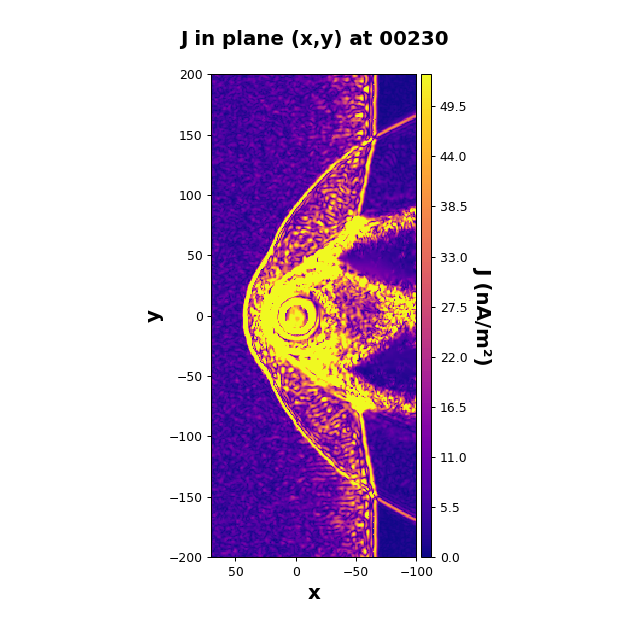

In [30]:
slice_x = slice(None)
slice_y = slice(None)
slice_z = slice(nz0-1, nz0+1)
slices = (slice_x, slice_y, slice_z)

mag_J_xy = np.sqrt(MD.Jx(B, slices)[:,:,1]**2 + MD.Jy(B, slices)[:,:,1]**2 + MD.Jz(B, slices)[:,:,1]**2)

plot_colormap(mag_J_xy, f'J in plane (x,y) at {time}', 'J (nA/m²)', 'xy',
              ratio_max_to_med = 80,
#               cubes = [cubes_xy_sw['right']['coord'],
#                        cubes_xy_bs['right']['coord'],
#                        cubes_xy_mp['right']['coord']],
              save_dir = storing_directory, t_label = time_label, zoom = zoom)

<IPython.core.display.Javascript object>


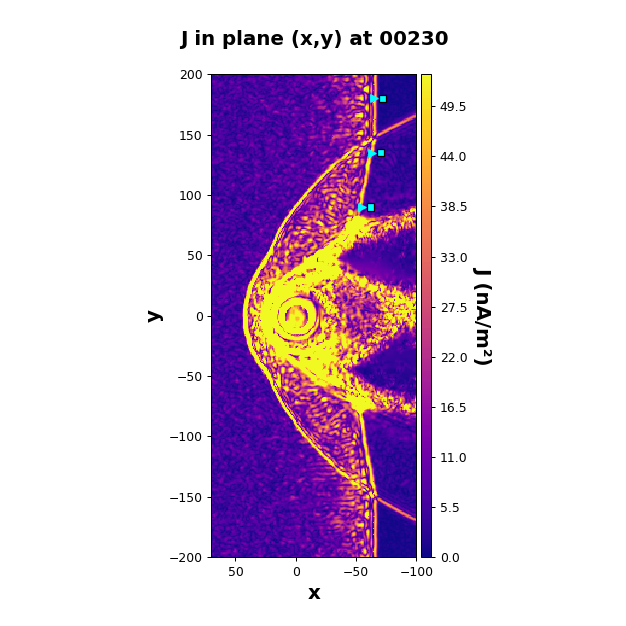

In [28]:
plot_colormap(mag_J_xy, f'J in plane (x,y) at {time}', 'J (nA/m²)', 'xy',
              ratio_max_to_med = 80, map_color='plasma',
              dashes = (position_shock_xy_sw, position_shock_xy_bs, position_shock_xy_mp),
              cubes = [cubes_xy_sw['right']['coord'],
                       cubes_xy_bs['right']['coord'],
                       cubes_xy_mp['right']['coord']],
              save_dir = storing_directory, t_label = time_label, zoom = zoom)

<IPython.core.display.Javascript object>


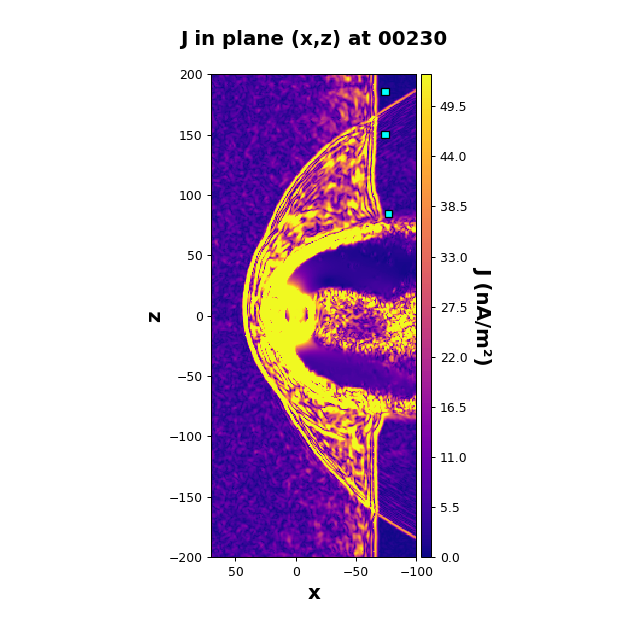

In [26]:
%matplotlib notebook

slice_x = slice(None)
slice_y = slice(ny0-1, ny0+1)
slice_z = slice(None)
slices = (slice_x, slice_y, slice_z)

mag_J_xz = np.sqrt(MD.Jx(B, slices)[:,1,:]**2 + MD.Jy(B, slices)[:,1,:]**2 + MD.Jz(B, slices)[:,1,:]**2)

plot_colormap(mag_J_xz, f'J in plane (x,z) at {time}', 'J (nA/m²)', 'xz',
              ratio_max_to_med = 80,
              cubes = [cubes_xz_sw['right']['coord'],
                       cubes_xz_bs['right']['coord'],
                       cubes_xz_mp['right']['coord']],
              save_dir = storing_directory, t_label = time_label, zoom = zoom)

<IPython.core.display.Javascript object>


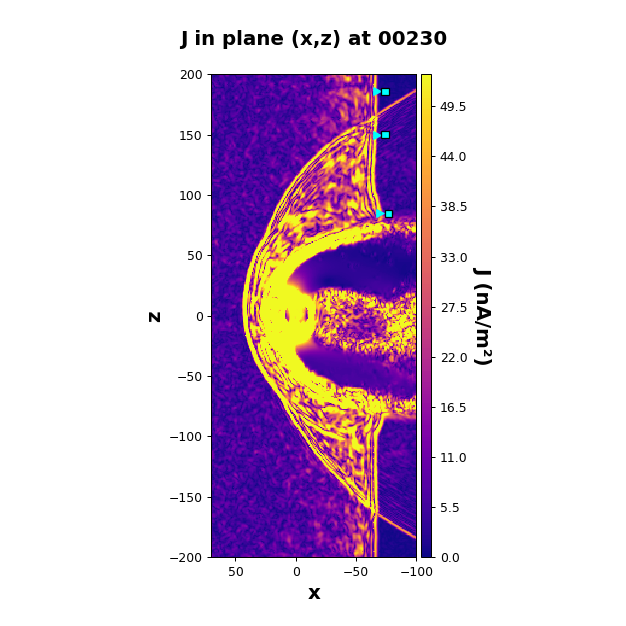

In [29]:
plot_colormap(mag_J_xz, f'J in plane (x,z) at {time}', 'J (nA/m²)', 'xz',
              ratio_max_to_med = 80,
              dashes = (position_shock_xz_sw, position_shock_xz_bs, position_shock_xz_mp),
              cubes = [cubes_xz_sw['right']['coord'],
                       cubes_xz_bs['right']['coord'],
                       cubes_xz_mp['right']['coord']],
              save_dir = storing_directory, t_label = time_label, zoom = zoom)

In [21]:
error

NameError: name 'error' is not defined

#### Velocity

<IPython.core.display.Javascript object>


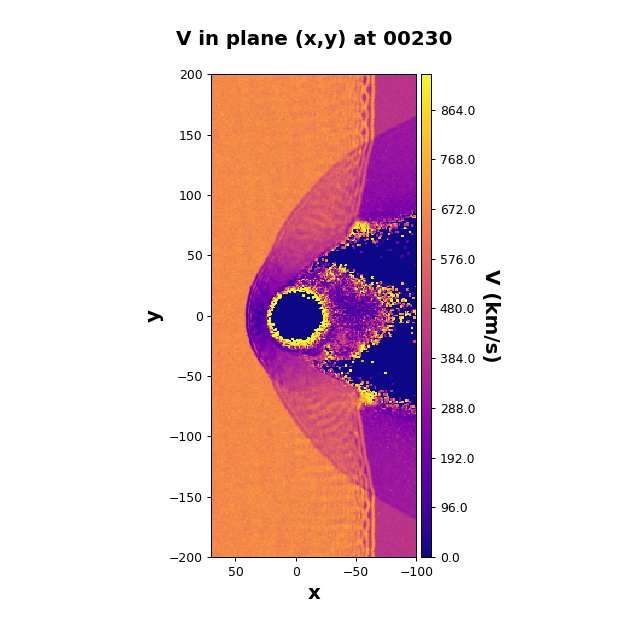

In [33]:
mag_V = np.sqrt( Vx[:,:,nz0]**2
                +Vy[:,:,nz0]**2
                +Vz[:,:,nz0]**2 )

np.nan_to_num(mag_V, 0)

plot_colormap(mag_V, title = f'V in plane (x,y) at {time}', label = 'V (km/s)', plane = 'xy',
              ratio_max_to_med = 1.4,
#               cubes = [cubes_xy_sw['right']['coord'],
#                        cubes_xy_bs['right']['coord'],
#                        cubes_xy_mp['right']['coord']],
                 save_dir = storing_directory, t_label = time_label, zoom = zoom)

#### Magnetic field

In [ ]:
mag_B = np.sqrt( Bx[:,:,nz0]**2
                +By[:,:,nz0]**2
                +Bz[:,:,nz0]**2 )

plot_colormap(mag_B, title = f'B in plane (x,y) at {time}', label = 'B (nT)', plane = 'xy',
              ratio_max_to_med = 1.4,
              save_dir = storing_directory, t_label = time_label, zoom = zoom,
              density = 17.5, streamplot = True, Bx = Bx[:,:,nz0], Bj = By[:,:,nz0])

In [ ]:
plot_colormap(Bx[:,:,nz0], title = f'Bx in plane (x,y) at {time}', label = 'Bx (nT)', plane = 'xy',
              save_dir = storing_directory, t_label = time_label, zoom = zoom)

plot_colormap(By[:,:,nz0], title = f'By in plane (x,y) at {time}', label = 'By (nT)', plane = 'xy',
              save_dir = storing_directory, t_label = time_label, zoom = zoom)

plot_colormap(Bz[:,:,nz0], title = f'Bz in plane (x,y) at {time}', label = 'Bz (nT)', plane = 'xy',
              save_dir = storing_directory, t_label = time_label, zoom = zoom)

## Generate relevant data

### Define cubes

In [ ]:
# Simple geometry assumption: shock normal is along x. This is not completely true.
# Should we do something about it? It's tough because we don't have that many grid cells to play with.


def function_data_in_cube(cube, data1, data2=None, function1=MD.identity, function_both=None):
    
    '''
    Returns the mean value of data in the different cubes.
    If data is a vector (len(data)==3), then the function returns the mean value the norm(data[cubes])
    '''
                  
    ixmin, ixmax, iymin, iymax, izmin, izmax = cube
        
    slices = (slice(ixmin, ixmax), slice(iymin, iymax), slice(izmin, izmax))
        
    if (not(data2)):                       
        result = function1( data1, slices )
            
    else:
        result = function_both( function1( data1, slices ), [data2[0][slices],
                                                             data2[1][slices],
                                                             data2[2][slices]] )
    data_in_cube = []        
    if (len(result) == 3):
        data_in_cube.append( (np.nanmean(result[0]), np.nanmean(result[1]), np.nanmean(result[2])) )
    else:
        data_in_cube.append( np.nanmean(result) )

        

    return data_in_cube

### Data in cubes

#### Draft values

In [ ]:
E_xy_left  = function_data_in_cube(cubes_xy['left' ], E, function1=MD.norm)[0]
E_xz_left  = function_data_in_cube(cubes_xz['left' ], E, function1=MD.norm)[0]

E_xy_right = function_data_in_cube(cubes_xy['right'], E, function1=MD.norm)[0]
E_xz_right = function_data_in_cube(cubes_xz['right'], E, function1=MD.norm)[0]

E_vec_xy_left  = function_data_in_cube(cubes_xy['left' ], E)[0]
E_vec_xz_left  = function_data_in_cube(cubes_xz['left' ], E)[0]

E_vec_xy_right = function_data_in_cube(cubes_xy['right'], E)[0]
E_vec_xz_right = function_data_in_cube(cubes_xz['right'], E)[0]

print(f"E_xy_left = {E_xy_left:0.1f} (mV)")
print(f"E_xz_left = {E_xz_left:0.1f} (mV)")

print(f"E_xy_right = {E_xy_right:0.1f} (mV)")
print(f"E_xz_right = {E_xz_right:0.1f} (mV)")

print(f"E_vec_xy_left = {E_vec_xy_left} (mV)")
print(f"E_vec_xz_left = {E_vec_xz_left} (mV)")

print(f"E_vec_xy_right = {E_vec_xy_right} (mV)")
print(f"E_vec_xz_right = {E_vec_xz_right} (mV)")

In [ ]:
cubes_xy = cubes(position_shock_xy, 'xy')
cubes_xz = cubes(position_shock_xz, 'xz')

In [ ]:
T_xy_left  = function_data_in_cube(cubes_xy['left' ], T)[0]
T_xz_left  = function_data_in_cube(cubes_xz['left' ], T)[0]

T_xy_right = function_data_in_cube(cubes_xy['right'], T)[0]
T_xz_right = function_data_in_cube(cubes_xz['right'], T)[0]

print(f"T_xy_left = {T_xy_left:.0f} (K)")
print(f"T_xz_left = {T_xz_left:.0f} (K)")

print(f"T_xy_right = {T_xy_right:.0f} (K)")
print(f"T_xz_right = {T_xz_right:.0f} (K)")

In [ ]:
J_xy_left = function_data_in_cube(cubes_xy['left'], B, function1=MD.J)[0]
J_xz_left = function_data_in_cube(cubes_xz['left'], B, function1=MD.J)[0]

J_xy_right = function_data_in_cube(cubes_xy['right'], B, function1=MD.J)[0]
J_xz_right = function_data_in_cube(cubes_xz['right'], B, function1=MD.J)[0]

Jx_xy_left = function_data_in_cube(cubes_xy['left'], B, function1=MD.Jx)[0]
Jx_xz_left = function_data_in_cube(cubes_xz['left'], B, function1=MD.Jx)[0]

Jx_xy_right = function_data_in_cube(cubes_xy['right'], B, function1=MD.Jx)[0]
Jx_xz_right = function_data_in_cube(cubes_xz['right'], B, function1=MD.Jx)[0]

Jy_xy_left = function_data_in_cube(cubes_xy['left'], B, function1=MD.Jy)[0]
Jy_xz_left = function_data_in_cube(cubes_xz['left'], B, function1=MD.Jy)[0]

Jy_xy_right = function_data_in_cube(cubes_xy['right'], B, function1=MD.Jy)[0]
Jy_xz_right = function_data_in_cube(cubes_xz['right'], B, function1=MD.Jy)[0]

Jz_xy_left = function_data_in_cube(cubes_xy['left'], B, function1=MD.Jz)[0]
Jz_xz_left = function_data_in_cube(cubes_xz['left'], B, function1=MD.Jz)[0]

Jz_xy_right = function_data_in_cube(cubes_xy['right'], B, function1=MD.Jz)[0]
Jz_xz_right = function_data_in_cube(cubes_xz['right'], B, function1=MD.Jz)[0]

In [ ]:
#conversion to SI:
b = 1e-9
n = 1e6
v = 1e3
t = 11605
#put pressure in nPa
p = 1e9

In [ ]:
Pmag_xy_left = function_data_in_cube(cubes_xy['left'], p*(b*MD.norm(B))**2/(2*MD.µ0))[0]
Pmag_xz_left = function_data_in_cube(cubes_xz['left'], p*(b*MD.norm(B))**2/(2*MD.µ0))[0]

Pmag_xy_right = function_data_in_cube(cubes_xy['right'], p*(b*MD.norm(B))**2/(2*MD.µ0))[0]
Pmag_xz_right = function_data_in_cube(cubes_xz['right'], p*(b*MD.norm(B))**2/(2*MD.µ0))[0]

print(f"Pmag_xy_left = {Pmag_xy_left:.1f} nPa")
print(f"Pmag_xz_left = {Pmag_xz_left:.1f} nPa")

print(f"Pmag_xy_right = {Pmag_xy_right:.1f} nPa")
print(f"Pmag_xz_right = {Pmag_xz_right:.1f} nPa")

In [ ]:
Pdyn_xy_left = function_data_in_cube(cubes_xy['left'], p*(1./2)*MD.mp*(n*N)*(v*MD.norm(V))**2)[0]
Pdyn_xz_left = function_data_in_cube(cubes_xz['left'], p*(1./2)*MD.mp*(n*N)*(v*MD.norm(V))**2)[0]

Pdyn_xy_right = function_data_in_cube(cubes_xy['right'], p*(1./2)*MD.mp*(n*N)*(v*MD.norm(V))**2)[0]
Pdyn_xz_right = function_data_in_cube(cubes_xz['right'], p*(1./2)*MD.mp*(n*N)*(v*MD.norm(V))**2)[0]

print(f"Pdyn_xy_left = {Pdyn_xy_left:.1f} nPa")
print(f"Pdyn_xz_left = {Pdyn_xz_left:.1f} nPa")

print(f"Pdyn_xy_right = {Pdyn_xy_right:.1f} nPa")
print(f"Pdyn_xz_right = {Pdyn_xz_right:.1f} nPa")

In [ ]:
Pth_xy_left = function_data_in_cube(cubes_xy['left'], p*MD.kB*(n*N)*(t*T))[0]
Pth_xz_left = function_data_in_cube(cubes_xz['left'], p*MD.kB*(n*N)*(t*T))[0]

Pth_xy_right = function_data_in_cube(cubes_xy['right'], p*MD.kB*(n*N)*(t*T))[0]
Pth_xz_right = function_data_in_cube(cubes_xz['right'], p*MD.kB*(n*N)*(t*T))[0]

print(f"Pth_xy_left = {Pth_xy_left:.1f} nPa")
print(f"Pth_xz_left = {Pth_xz_left:.1f} nPa")

print(f"Pth_xy_right = {Pth_xy_right:.1f} nPa")
print(f"Pth_xz_right = {Pth_xz_right:.1f} nPa")

In [ ]:
# VA_xy_left = B_xy_left*b / np.sqrt(MD.µ0 * MD.mp * N_xy_left*n) / v

# va_test_1 = VA_xy_left
# va_test_2 = np.sqrt(2*Pmag_xy_left/p / (MD.mp * N_xy_left*n)) / v
# digits = 3
# print(va_test_1, va_test_2)

In [ ]:
VA_xy_left = B_xy_left*b / np.sqrt(MD.µ0 * MD.mp * N_xy_left*n) / v
VA_xz_left = B_xz_left*b / np.sqrt(MD.µ0 * MD.mp * N_xz_left*n) / v

VA_xy_right = B_xy_right*b / np.sqrt(MD.µ0 * MD.mp * N_xy_right*n) / v
VA_xz_right = B_xz_right*b / np.sqrt(MD.µ0 * MD.mp * N_xz_right*n) / v


print(f"VA_xy_left = {VA_xy_left:.0f} (km/s)")
print(f"VA_xz_left = {VA_xz_left:.0f} (km/s)")

print(f"VA_xy_right = {VA_xy_right:.0f} (km/s)")
print(f"VA_xz_right = {VA_xz_right:.0f} (km/s)")

#### Proper def

In [ ]:
def all_info(cubes):
    B_left  = function_data_in_cube(cubes['left' ]['index'], B, function1=MD.norm)[0]
    B_right = function_data_in_cube(cubes['right']['index'], B, function1=MD.norm)[0]
    
    B_vec_left  = function_data_in_cube(cubes['left' ]['index'], B)[0]
    B_vec_right = function_data_in_cube(cubes['right']['index'], B)[0]
    
    V_left  = function_data_in_cube(cubes['left' ]['index'], V, function1=MD.norm)[0]
    V_right = function_data_in_cube(cubes['right']['index'], V, function1=MD.norm)[0]
    
    V_vec_left  = function_data_in_cube(cubes['left' ]['index'], V)[0]
    V_vec_right = function_data_in_cube(cubes['right']['index'], V)[0]
    
    N_left  = function_data_in_cube(cubes['left' ]['index'], N)[0]
    N_right = function_data_in_cube(cubes['right']['index'], N)[0]
    
    V_shock = (N_left*V_left - N_right*V_right) / (N_left - N_right)
    
    dic = {'B_left': B_left, 'B_right': B_right,
           'B_vec_left': B_vec_left, 'B_vec_right': B_vec_right,
           'V_left': V_left, 'V_right': V_right,
           'V_vec_left': V_vec_left, 'V_vec_right': V_vec_right,
           'N_left': N_left, 'N_right': N_right,
           'V_shock': V_shock}
    
#     print(dic)
    
    return dic

## Check Hypotheses

### Shock velocity constant in plasma frame / The IP shock "rides" the bulk plasma $$(v_s-v_{bulk})^{sw} = (v_s-v_{bulk})^{msh}$$

In [ ]:
#Method_1, compute V_shock with Rankine-Hugoniot

for cubes in [cubes_xy_sw, cubes_xy_bs, cubes_xy_mp]:
    print(all_info(cubes)['V_shock'] - all_info(cubes)['V_right'])
    
for cubes in [cubes_xz_sw, cubes_xz_bs, cubes_xz_mp]:
    print(all_info(cubes)['V_shock'] - all_info(cubes)['V_right'])

In [ ]:
# for cubes in [cubes_xy_sw, cubes_xy_bs, cubes_xy_mp]:
#     print(all_info(cubes)['V_shock'])
    
# for cubes in [cubes_xz_sw, cubes_xz_bs, cubes_xz_mp]:
#     print(all_info(cubes)['V_shock'])   

In [ ]:
#Method_2, Use Shock_tracking_read_slices to compute V_shock

V_shock_sw_y180 = 792
V_shock_bs_y135 = 660
V_shock_mp_y90  = 645

V_shock_sw_z186 = 782
V_shock_bs_z150 = 760
V_shock_mp_z80  = 911

for (v,cubes) in [(V_shock_sw_y180, cubes_xy_sw), (V_shock_bs_y135, cubes_xy_bs), (V_shock_mp_y90, cubes_xy_mp)]:
    print(v - all_info(cubes)['V_right'])
    
for (v,cubes) in [(V_shock_sw_z186, cubes_xz_sw), (V_shock_bs_z150, cubes_xz_bs), (V_shock_mp_z80, cubes_xz_mp)]:
    print(v - all_info(cubes)['V_right'])

In [ ]:
def uncertainty(cubes):
    ixmin, ixmax, iymin, iymax, izmin, izmax = cubes['right' ]['index']
    return np.std(MD.norm(V)[ixmin:ixmax, iymin:iymax, izmin:izmax])

In [ ]:
for cubes in [cubes_xy_sw, cubes_xy_bs, cubes_xy_mp]:
    print(uncertainty(cubes))
    
for cubes in [cubes_xz_sw, cubes_xz_bs, cubes_xz_mp]:
    print(uncertainty(cubes))

In [ ]:
for cubes in [cubes_xy_sw, cubes_xy_bs, cubes_xy_mp]:
    print("xy")
    print(np.sqrt(20**2+uncertainty(cubes)**2))
    
for cubes in [cubes_xz_sw, cubes_xz_bs, cubes_xz_mp]:
    print("xz")
    print(np.sqrt(20**2+uncertainty(cubes)**2))